In [244]:
import os
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
import pubchempy as pcp
os.chdir('../')
from util.util import *
os.chdir('notebooks')


import IPython.display as Disp

# Determining Top Candidates Robustly

In [246]:
def find_top_mols(pl_data, org_data, org_smiles, best_orgs, scaling_factor=1):
    rand_idxs = np.random.choice(np.arange(len(pl_data)), size=len(pl_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    
    pl_train = pl_data[train_idxs,:]
    pl_test = pl_data[test_idxs,:]
    
    rand_idxs = np.random.choice(np.arange(len(org_data)), size=len(org_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    org_train = org_data[train_idxs,:]
    org_test = org_data[test_idxs,:]
    org_smiles_test = org_smiles[test_idxs]
    
    train_data = np.concatenate([pl_train, org_train], axis=0)
    test_data = np.concatenate([pl_test, org_test], axis=0)
    
    scaler = MinMaxScaler([0,1*scaling_factor])
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    pca = PCA(n_components=2)
    train_ics = pca.fit_transform(train_data)
    test_ics = pca.transform(test_data)

    pl_ics = train_ics[:168,:]
    org_ics = train_ics[168:,:]
    test_pl_ics = test_ics[:42,:]
    test_org_ics = test_ics[42:,:]
    
    pc1_all = np.concatenate([pl_ics[:,0], org_ics[:,0], test_pl_ics[:,0], test_org_ics[:,0]], axis=0)
    pc1_min = math.floor(pc1_all.min())
    pc1_max = math.ceil(pc1_all.max())
    pc2_all = np.concatenate([pl_ics[:,1], org_ics[:,1], test_pl_ics[:,1], test_org_ics[:,1]], axis=0)
    pc2_min = math.floor(pc2_all.min())
    pc2_max = math.ceil(pc2_all.max())
    
    kde, xs, ys = calc_2D_kde(pl_ics, [pc1_min, pc1_max], [pc2_min, pc2_max])
    pl_test_kdes = []
    pl_train_kdes = []
    org_kdes = []
    for pl_sample in test_pl_ics:
        pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for pl_sample in pl_ics:
        pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for org_sample in test_org_ics:
        org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))
    
    org_hits_kde_best, org_hits_sm_best = zip(*reversed(sorted(zip(org_kdes, org_smiles_test))))
    for i, smile in enumerate(org_hits_sm_best):
        best_orgs[smile][0] += 1
        best_orgs[smile][1] += org_hits_kde_best[i]
    return best_orgs


def lasso_selection(pl_data, org_data, org_smiles, best_orgs, scaling_factor=1):
    rand_idxs = np.random.choice(np.arange(len(pl_data)), size=len(pl_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]

    pl_train = pl_data[train_idxs,:]
    pl_test = pl_data[test_idxs,:]

    rand_idxs = np.random.choice(np.arange(len(org_data)), size=len(org_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    org_train = org_data[train_idxs,:]
    org_test = org_data[test_idxs,:]
    org_smiles_test = org_smiles[test_idxs]

    train_data = np.concatenate([pl_train, org_train], axis=0)
    test_data = np.concatenate([pl_test, org_test], axis=0)
    np.random.shuffle(train_data)

    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]
    X_test = test_data[:,:-1]
    y_test = test_data[:,-1]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
    sel_.fit(X_train, y_train)
    
    X_train_sel = X_train[:,sel_.get_support()]
    X_test_sel = X_test[:,sel_.get_support()]
    
    pca = PCA(n_components=2)
    train_ics = pca.fit_transform(X_train_sel)
    test_ics = pca.transform(X_test_sel)
    
    pl_ics = train_ics[np.where(y_train == 1)]
    org_ics = train_ics[np.where(y_train == 0)]
    test_pl_ics = test_ics[np.where(y_test == 1)]
    test_org_ics = test_ics[np.where(y_test == 0)]
    
    pc1_all = np.concatenate([pl_ics[:,0], org_ics[:,0], test_pl_ics[:,0], test_org_ics[:,0]], axis=0)
    pc1_min = math.floor(pc1_all.min())
    pc1_max = math.ceil(pc1_all.max())
    pc2_all = np.concatenate([pl_ics[:,1], org_ics[:,1], test_pl_ics[:,1], test_org_ics[:,1]], axis=0)
    pc2_min = math.floor(pc2_all.min())
    pc2_max = math.ceil(pc2_all.max())
    
    kde, xs, ys = calc_2D_kde(pl_ics, [pc1_min, pc1_max], [pc2_min, pc2_max])
    pl_test_kdes = []
    pl_train_kdes = []
    org_kdes = []
    for pl_sample in test_pl_ics:
        pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for pl_sample in pl_ics:
        pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for org_sample in test_org_ics:
        org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))
    
    org_hits_kde_best, org_hits_sm_best = zip(*reversed(sorted(zip(org_kdes, org_smiles_test))))
    for i, smile in enumerate(org_hits_sm_best):
        best_orgs[smile][0] += 1
        best_orgs[smile][1] += org_hits_kde_best[i]
    return best_orgs


## Fingerprints Only

In [235]:
# Load Data
pl_data = pd.read_pickle('../data/pubchem/fingerprints/plasticizer_fingerprints.pkl')
pl_data = pl_data[(pl_data.T != 0).any()]
org_data = pd.read_pickle('../data/pubchem/fingerprints/organic_fingerprints.pkl')
org_data = org_data[(org_data.T != 0).any()]
org_cols = org_data.columns.to_list()
org_cols[0] = 'SMILES'
org_data.columns = org_cols

pl_smiles = pl_data['SMILES'].to_numpy()
pl_fps = pl_data[pl_data.columns[1:]].to_numpy()
org_data = org_data.sample(n=org_data.shape[0])
org_smiles = org_data['SMILES'].to_numpy()
org_fps = org_data[org_data.columns[1:]].to_numpy()

In [236]:
best_orgs = {}
for smile in org_smiles:
    best_orgs[smile] = [0, 0]

In [237]:
for k in range(100):
     best_orgs = find_top_mols(pl_fps, org_fps, org_smiles, best_orgs, scaling_factor=0.1)

In [238]:
best_smiles_by_count = []
best_smiles_by_score = []
best_smiles_by_avg_score = []
best_counts = []
best_score = []
best_avg_score = []

for k, v in best_orgs.items():
    best_smiles_by_count.append(k)
    best_smiles_by_score.append(k)
    best_smiles_by_avg_score.append(k)
    best_counts.append(v[0])
    best_score.append(v[1])
    try:
        best_avg_score.append(v[1] / v[0])
    except ZeroDivisionError:
        best_avg_score.append(0)

In [239]:
best_avg_score, best_smiles_by_avg_score, best_counts, best_score = zip(*reversed(sorted(zip(best_avg_score, best_smiles_by_avg_score, best_counts, best_score))))


In [240]:
sm_avg_sc = pd.Series(best_smiles_by_avg_score)
avg_sc = pd.Series(best_avg_score)
sc = pd.Series(best_score)
cnts = pd.Series(best_counts)
fps_data_dict = {'SMILES':sm_avg_sc,
                 'Avg. Score':avg_sc,
                 'Score':sc,
                 'Counts':cnts}
best_orgs_fps = pd.DataFrame(fps_data_dict)

In [242]:
best_orgs_fps.to_pickle('org_ll_analysis/best_orgs_fps.pkl')

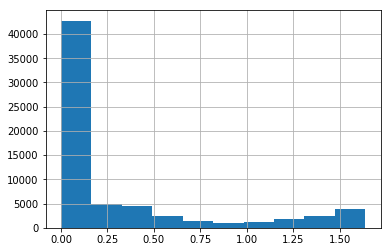

In [243]:
best_orgs_fps['Avg. Score'].hist()

## Descriptors Only (LASSO Selected)

In [248]:
pl_desc = pd.read_excel('../database/plasticizer_data_v5_rdkit.xls')
pl_desc = pl_desc[pl_desc.columns[1:]]

org_data = pd.read_pickle('../data/pubchem/descriptors/org_chem_pubc.pkl')
org_desc = org_data[~org_data.isin([np.nan, np.inf, -np.inf]).any(1)]
org_desc = org_desc.reset_index(drop=True)

shared_cols = set(pl_desc.columns).intersection(set(org_desc.columns))
shared_cols = shared_cols - set(['SMILES', 'Ipc'])

pl_desc = pl_desc[shared_cols]
org_desc = org_desc[shared_cols]
ones = np.ones((pl_desc.shape[0],1))
zeros = np.zeros((org_desc.shape[0],1))
pl_desc = np.hstack((pl_desc, ones))
org_desc = np.hstack((org_desc, zeros))
org_smiles = org_data['SMILES'].to_numpy()

In [249]:
best_orgs = {}
for smile in org_smiles:
    best_orgs[smile] = [0, 0]

In [250]:
for k in range(100):
    print(k)
    best_orgs = lasso_selection(pl_desc, org_desc, org_smiles, best_orgs)

0


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


8


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


15


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


16


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


17


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


18


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


19


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


20


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


21


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


22


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


23


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


24


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


25


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


26


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


27


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


28


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


29


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


30


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


31


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


32


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


33


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


34


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


35


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


36


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


37


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


38


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


39


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


40


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


41


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


42


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


43


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


44


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


45


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


46


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


47


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


48


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


49


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


50


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


51


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


52


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


53


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


54


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


55


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


56


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


57


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


58


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


59


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


60


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


61


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


62


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


63


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


64


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


65


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


66


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


67


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


68


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


69


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


70


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


71


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


72


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


73


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


74


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


75


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


76


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


77


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


78


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


79


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


80


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


81


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


82


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


83


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


84


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


85


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


86


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


87


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


88


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


89


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


90


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


91


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


92


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


93


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


94


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


95


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


96


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


97


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


98


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


99


/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [251]:
best_smiles_by_count = []
best_smiles_by_score = []
best_smiles_by_avg_score = []
best_counts = []
best_score = []
best_avg_score = []

for k, v in best_orgs.items():
    best_smiles_by_count.append(k)
    best_smiles_by_score.append(k)
    best_smiles_by_avg_score.append(k)
    best_counts.append(v[0])
    best_score.append(v[1])
    try:
        best_avg_score.append(v[1] / v[0])
    except ZeroDivisionError:
        best_avg_score.append(0)

In [252]:
best_avg_score, best_smiles_by_avg_score, best_counts, best_score = zip(*reversed(sorted(zip(best_avg_score, best_smiles_by_avg_score, best_counts, best_score))))





In [253]:
sm_avg_sc = pd.Series(best_smiles_by_avg_score)
avg_sc = pd.Series(best_avg_score)
sc = pd.Series(best_score)
cnts = pd.Series(best_counts)
desc_data_dict_lasso = {'SMILES':sm_avg_sc,
                        'Avg. Score':avg_sc,
                        'Score':sc,
                        'Counts':cnts}
best_orgs_desc_lasso = pd.DataFrame(desc_data_dict_lasso)

In [255]:
best_orgs_desc_lasso.to_pickle('org_ll_analysis/best_orgs_desc_lasso.pkl')

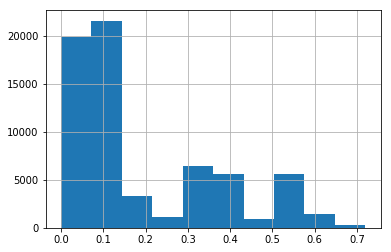

In [256]:
best_orgs_desc_lasso['Avg. Score'].hist()

## Descriptors Only (All Features)

In [261]:
pl_desc = pd.read_excel('../database/plasticizer_data_v5_rdkit.xls')
pl_desc = pl_desc[pl_desc.columns[1:]]

org_data = pd.read_pickle('../data/pubchem/descriptors/org_chem_pubc.pkl')
org_desc = org_data[~org_data.isin([np.nan, np.inf, -np.inf]).any(1)]
org_desc = org_desc.reset_index(drop=True)

shared_cols = set(pl_desc.columns).intersection(set(org_desc.columns))
shared_cols = shared_cols - set(['SMILES', 'Ipc'])

pl_desc = pl_desc[shared_cols].to_numpy()
org_desc = org_desc[shared_cols].to_numpy()
org_smiles = org_data['SMILES'].to_numpy()

In [262]:
best_orgs = {}
for smile in org_smiles:
    best_orgs[smile] = [0, 0]

In [263]:
for k in range(100):
    print(k)
    best_orgs = find_top_mols(pl_desc, org_desc, org_smiles, best_orgs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [264]:
best_smiles_by_count = []
best_smiles_by_score = []
best_smiles_by_avg_score = []
best_counts = []
best_score = []
best_avg_score = []

for k, v in best_orgs.items():
    best_smiles_by_count.append(k)
    best_smiles_by_score.append(k)
    best_smiles_by_avg_score.append(k)
    best_counts.append(v[0])
    best_score.append(v[1])
    try:
        best_avg_score.append(v[1] / v[0])
    except ZeroDivisionError:
        best_avg_score.append(0)

In [265]:
best_avg_score, best_smiles_by_avg_score, best_counts, best_score = zip(*reversed(sorted(zip(best_avg_score, best_smiles_by_avg_score, best_counts, best_score))))



In [266]:
sm_avg_sc = pd.Series(best_smiles_by_avg_score)
avg_sc = pd.Series(best_avg_score)
sc = pd.Series(best_score)
cnts = pd.Series(best_counts)
desc_data_dict = {'SMILES':sm_avg_sc,
                  'Avg. Score':avg_sc,
                  'Score':sc,
                  'Counts':cnts}
best_orgs_desc = pd.DataFrame(desc_data_dict)

In [268]:
best_orgs_desc.to_pickle('org_ll_analysis/best_orgs_desc.pkl')

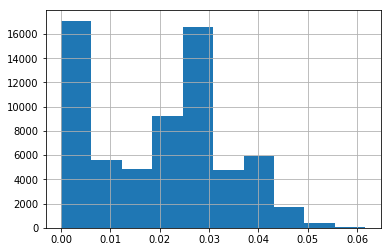

In [269]:
best_orgs_desc['Avg. Score'].hist()

In [270]:
best_orgs_desc.head()

,SMILES,Avg. Score,Score,Counts
0,C1=CC=C2C=C(C=CC2=C1)N(CCCl)CCCl,0.061653,6.103671,99
1,C1=CC(=CC=C1NCCNC2=CC=C(C=C2)[As](=O)(O)O)[As]...,0.061245,6.002003,98
2,CC[C@@H]1[C@@]([C@@H]([C@H](N(C[C@@H](C[C@@]([...,0.061240,6.062725,99
3,C/C/1=C/CC[C@@]2([C@@H](O2)[C@@H]3[C@@H](CC1)C...,0.061240,6.062725,99
4,CC1=CC(=C(C(=C1)SC2=CC(=CC(=C2O)C(C)(C)C)C)O)C...,0.061039,6.103861,100


## Descriptors and Fingerprints

In [278]:
org_data = pd.read_pickle('../data/pubchem/org_desc_fps.pkl')
pl_data = pd.read_pickle('../database/plasticizer_data_v6_desc_fps.pkl')
pl_data.columns = [str(x) for x in pl_data.columns]

org_all = org_data[~org_data.isin([np.nan, np.inf, -np.inf]).any(1)]
org_all = org_all.reset_index(drop=True)

shared_cols = set(pl_data.columns).intersection(set(org_all.columns))
shared_cols = shared_cols - set(['SMILES', 'Ipc'])

pl_all = pl_data[shared_cols].to_numpy()
org_all = org_all[shared_cols].to_numpy()
org_smiles = org_data['SMILES'].to_numpy()

In [292]:
pl_sets, org_sets = pca_data_split(pl_data, org_data, n=10000, cols=shared_cols)
pl_ics, org_ics = run_pca(pl_sets, org_sets)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [286]:
best_orgs = {}
for smile in org_smiles:
    best_orgs[smile] = [0, 0]

In [287]:
best_orgs = find_top_mols(pl_all, org_all, org_smiles, best_orgs)

In [288]:
best_smiles_by_count = []
best_smiles_by_score = []
best_smiles_by_avg_score = []
best_counts = []
best_score = []
best_avg_score = []

for k, v in best_orgs.items():
    best_smiles_by_count.append(k)
    best_smiles_by_score.append(k)
    best_smiles_by_avg_score.append(k)
    best_counts.append(v[0])
    best_score.append(v[1])
    try:
        best_avg_score.append(v[1] / v[0])
    except ZeroDivisionError:
        best_avg_score.append(0)

In [289]:
best_avg_score, best_smiles_by_avg_score, best_counts, best_score = zip(*reversed(sorted(zip(best_avg_score, best_smiles_by_avg_score, best_counts, best_score))))


In [290]:
sm_avg_sc = pd.Series(best_smiles_by_avg_score)
avg_sc = pd.Series(best_avg_score)
sc = pd.Series(best_score)
cnts = pd.Series(best_counts)
all_data_dict = {'SMILES':sm_avg_sc,
                 'Avg. Score':avg_sc,
                 'Score':sc,
                 'Counts':cnts}
best_orgs_all = pd.DataFrame(all_data_dict)

In [291]:
best_orgs_all

,SMILES,Avg. Score,Score,Counts
0,OS(=O)(=O)OS(=O)(=O)O,0.017437,0.017437,1
1,C[N+](C)(CCCCCC[N+](C)(C)C1C2=CC=CC=C2C3=CC=CC...,0.017437,0.017437,1
2,C[N+](C)(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl.[I-],0.017437,0.017437,1
3,C[N+](C)(C)C.Cl.[Cl-],0.017437,0.017437,1
4,C[C@]12CC[C@H]3[C@]([C@@H]1CC4=C(O2)C=CC(=C4)C...,0.017437,0.017437,1
5,C[C@]12CC[C@H]3[C@H]([C@@H]1CCC2=O)CCC4=CC(=C(...,0.017437,0.017437,1
6,C[C@]12CC[C@H]3[C@H]([C@@H]1CCC2=O)CCC4=C3C=CC...,0.017437,0.017437,1
7,C[C@]12CCC(=O)C=C1[C@@H]([C@H]([C@@H]3[C@@H]2C...,0.017437,0.017437,1
8,C[C@](CC1=CC(=C(C=C1)O)O)(C(=O)O)NN,0.017437,0.017437,1
9,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,0.017437,0.017437,1


# Molecular Fingerprints

In [94]:
pl_data = pd.read_pickle('../data/pubchem/fingerprints/plasticizer_fingerprints.pkl')
pl_data = pl_data[(pl_data.T != 0).any()]
org_data = pd.read_pickle('../data/pubchem/fingerprints/organic_fingerprints.pkl')
org_data = org_data[(org_data.T != 0).any()]
org_cols = org_data.columns.to_list()
org_cols[0] = 'SMILES'
org_data.columns = org_cols

In [143]:
pl_smiles = pl_data['SMILES'].to_numpy()
pl_fps = pl_data[pl_data.columns[1:]].to_numpy()
org_data = org_data.sample(500)
org_smiles = org_data['SMILES'].to_numpy()
org_fps = org_data[org_data.columns[1:]].to_numpy()

In [144]:
rand_idxs = np.random.choice(np.arange(len(pl_fps)), size=len(pl_fps), replace=False)
train_idxs = rand_idxs[:168]
test_idxs = rand_idxs[168:]

pl_train = pl_fps[train_idxs,:]
pl_smiles_train = pl_smiles[train_idxs]
pl_test = pl_fps[test_idxs,:]
pl_smiles_test = pl_smiles[test_idxs]
org_train = org_fps[:168,:]
org_smiles_train = org_smiles[:168]
org_test = org_fps[168:,:]
org_smiles_test = org_smiles[168:]

train_data = np.concatenate([pl_train, org_train], axis=0)
test_data = np.concatenate([pl_test, org_test], axis=0)

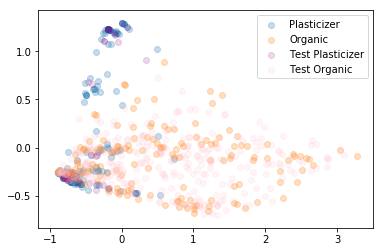

In [145]:
scaler = MinMaxScaler([0,0.1])
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
pca = PCA(n_components=2)
train_ics = pca.fit_transform(train_data)
test_ics = pca.transform(test_data)

pl_ics = train_ics[:168,:]
org_ics = train_ics[168:,:]
test_pl_ics = test_ics[:42,:]
test_org_ics = test_ics[42:,:]

plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizer', alpha=0.25)
plt.scatter(org_ics[:,0], org_ics[:,1], label='Organic', alpha=0.25)
plt.scatter(test_pl_ics[:,0], test_pl_ics[:,1], label='Test Plasticizer', alpha=0.15, c='purple')
plt.scatter(test_org_ics[:,0], test_org_ics[:,1], label='Test Organic', alpha=0.15, c='pink')
plt.legend(loc='best')
plt.show()

In [146]:
kde, xs, ys = calc_2D_kde(pl_ics, [-1.5,3.5], [-1.0,2.0])

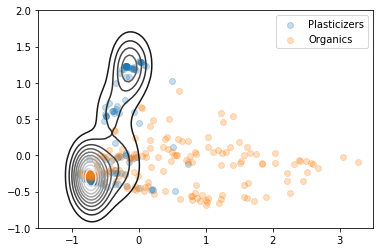

In [147]:
plt.contour(xs, ys, kde, levels=10, cmap='gray')
plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizers', alpha=0.25)
plt.scatter(org_ics[:,0], org_ics[:,1], label='Organics', alpha=0.25)
plt.legend(loc='best')
plt.show()

In [148]:
pl_test_kdes = []
pl_train_kdes = []
org_kdes = []
for pl_sample in test_pl_ics:
    pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for pl_sample in pl_ics:
    pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for org_sample in test_org_ics:
    org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))

In [149]:
boundary = 0.2
pl_train_acc = eval_acc(pl_train_kdes, boundary)
pl_test_acc = eval_acc(pl_test_kdes, boundary)
org_hit_percent = eval_acc(org_kdes, boundary)
print("Train Accuracy - {}%".format(round(pl_train_acc*100, 2)))
print("Test Accuracy - {}%".format(round(pl_test_acc*100, 2)))
print("Org Hit Percent - {}% ({} / {} samples)".format(round(org_hit_percent*100, 2), int(org_hit_percent*len(org_kdes)), len(org_kdes)))

Train Accuracy - 92.86%
Test Accuracy - 95.24%
GDB Hit Percent - 30.42% (101 / 332 samples)


In [150]:
org_hits_sm = org_smiles_test[np.where(np.array(org_kdes) > 0.2)]
org_hits_kde = np.array(org_kdes)[np.where(np.array(org_kdes) > 0.2)]
org_hits_kde_best, org_hits_sm_best = zip(*reversed(sorted(zip(org_hits_kde, org_hits_sm))))

In [153]:
urls = []
for hit in org_hits_sm_best:
    url = 'https://cactus.nci.nih.gov/chemical/structure/{}/image'.format(hit)
    urls.append(url)

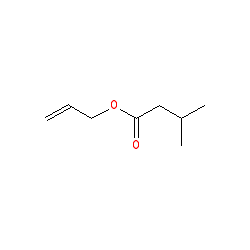

In [155]:
Disp.Image(requests.get(urls[0]).content)

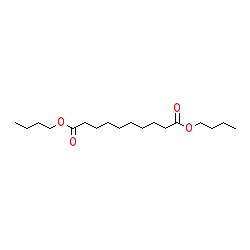

In [156]:
Disp.Image(requests.get(urls[1]).content)

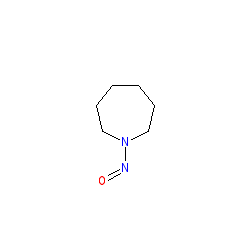

In [157]:
Disp.Image(requests.get(urls[2]).content)

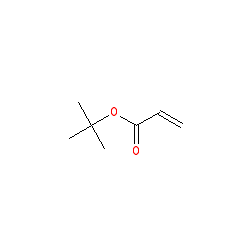

In [158]:
Disp.Image(requests.get(urls[3]).content)

Fingerprints by themselves are an improvement over chemical properties by themselves. The top candidates are much more realistic than GDB (obviously). The presence of a polar functional group seems to take precedence over the space occupying functionality of the alkyl chains. Seems like adding a parameter like molar volume could really help improve the predictions.

# Picking Columns By Mean Diffs

In [2]:
# plasticizers = pd.read_pickle('../database/plasticizer_data_v5_high_var.pkl')
plasticizers = pd.read_excel('../database/plasticizer_data_v5_rdkit.xls')
plasticizers = plasticizers[plasticizers.columns[1:]]
plasticizers = plasticizers.loc[:, (plasticizers != 0).any(axis=0)]
rdkit_cols = np.array(plasticizers.columns[5:])
rdkit_cols = rdkit_cols[np.where(rdkit_cols != 'Ipc')]

In [3]:
organics = pd.read_pickle('../data/pubchem/org_chem_pubc.pkl')
organics = organics[~organics.isin([np.nan, np.inf, -np.inf]).any(1)]
drop_rows = []
for i, row in organics.iterrows():
    row = row[-85:].to_numpy()
    if -666.0 in row:
        drop_rows.append(i)
organics = organics.drop(drop_rows, axis=0)
organics = organics.reset_index(drop=True)
organics = organics.loc[:, (organics != 0).any(axis=0)]

In [4]:
glycolips = pd.read_pickle('../data/pubchem/glycolipid_pubc.pkl')
glycolips = glycolips.loc[:, (glycolips != 0).any(axis=0)]

In [5]:
shared_cols = set(plasticizers.columns).intersection(set(organics.columns), set(glycolips.columns))
shared_cols = shared_cols - set(['SMILES', 'Ipc'])

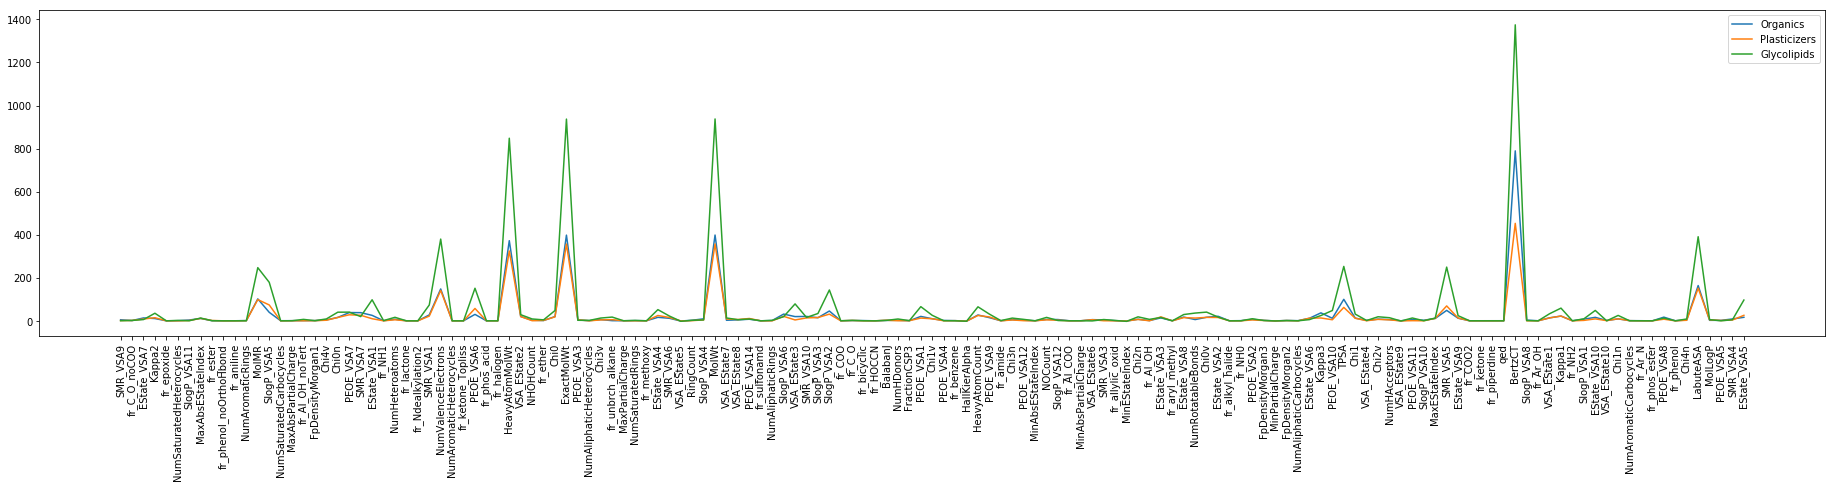

In [6]:
org_means = []
pl_means = []
glip_means = []
for col in shared_cols:
    org_means.append(organics[col].mean())
    pl_means.append(plasticizers[col].mean())
    glip_means.append(glycolips[col].mean())
plt.figure(figsize=(32,6))
plt.plot(org_means, label='Organics')
plt.plot(pl_means, label='Plasticizers')
plt.plot(glip_means, label='Glycolipids')
plt.legend(loc='best')
plt.xticks(range(len(shared_cols)), labels=shared_cols, rotation='vertical')
plt.show()

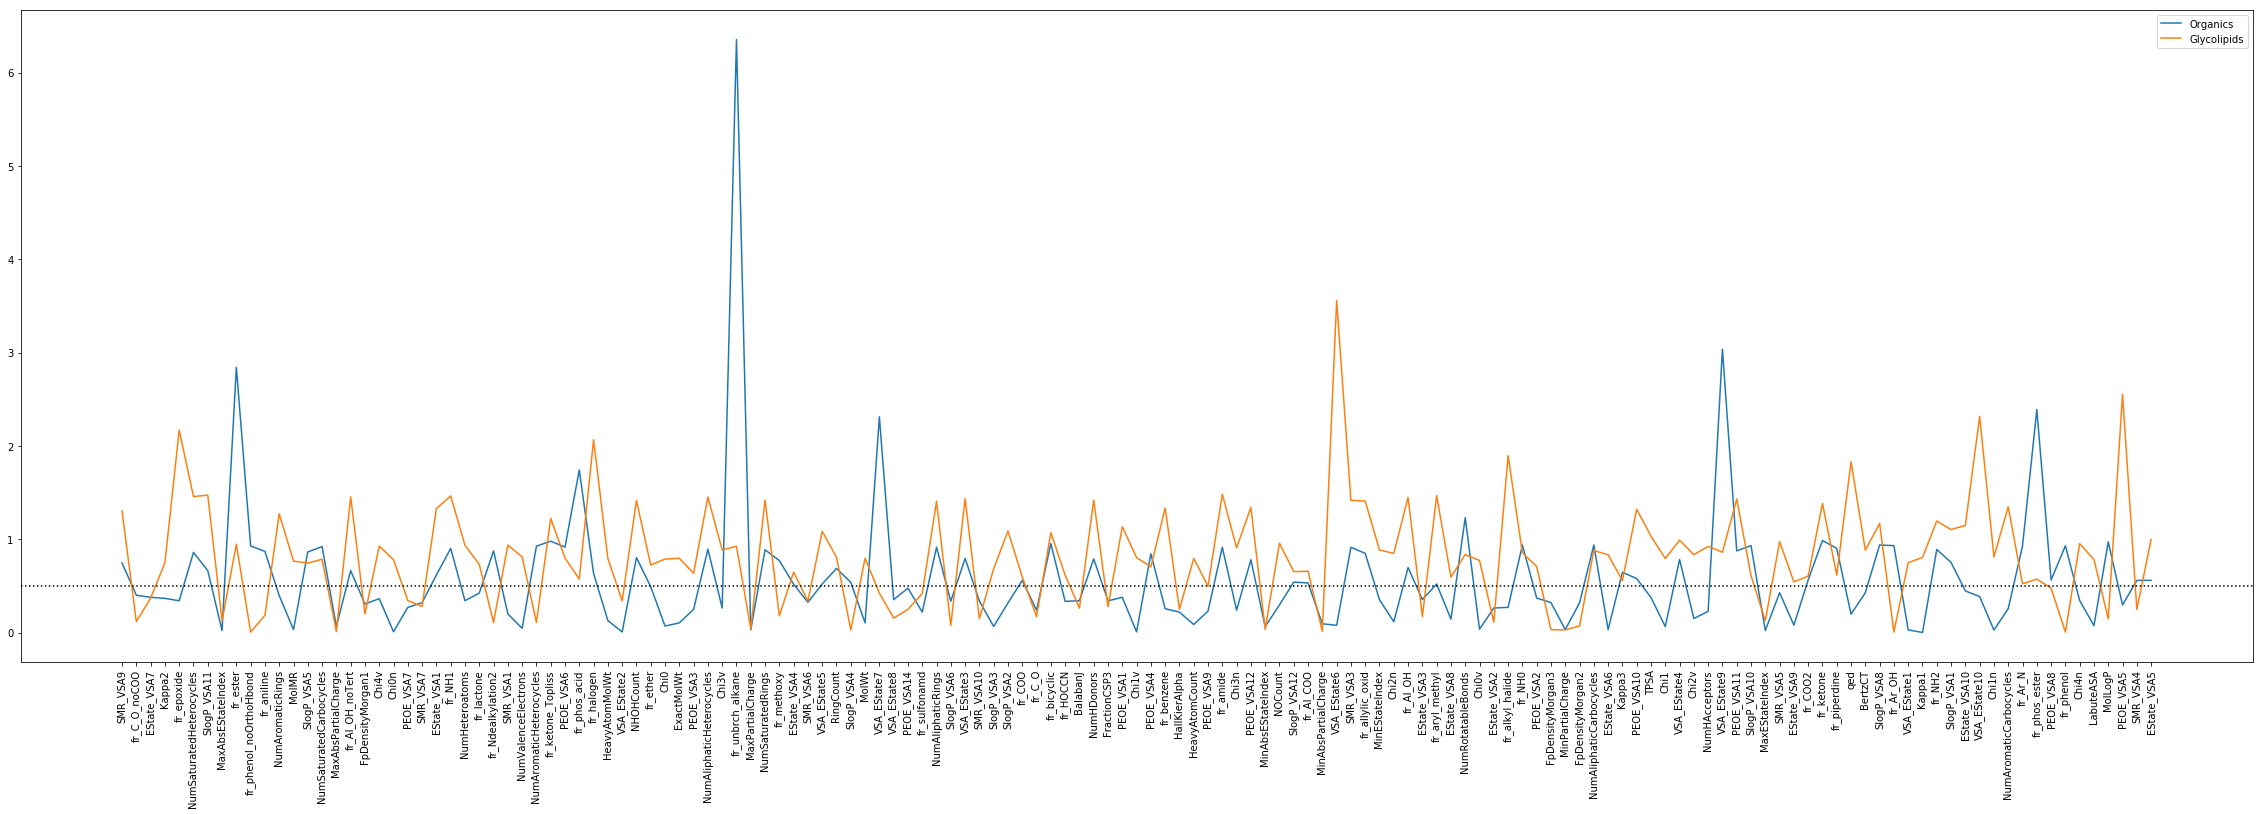

In [32]:
cutoff = 0.5
avg_dif_org = []
avg_dif_glip = []
for col in shared_cols:
    org_mean = organics[col].mean()
    pl_mean = plasticizers[col].mean()
    glip_mean = glycolips[col].mean()
    org_pl_mean = np.mean(np.concatenate([organics[col].to_numpy(), plasticizers[col].to_numpy()], axis=0))
    glip_pl_mean = np.mean(np.concatenate([glycolips[col].to_numpy(), plasticizers[col].to_numpy()]), axis=0)
    avg_dif_org.append(abs(pl_mean - org_mean) / abs(org_pl_mean))
    avg_dif_glip.append(abs(pl_mean - glip_mean) / abs(glip_pl_mean))
plt.figure(figsize=(40,12))
plt.plot(avg_dif_org, label='Organics')
plt.plot(avg_dif_glip, label='Glycolipids')
plt.legend(loc='best')
plt.xticks(range(len(shared_cols)), labels=shared_cols, rotation='vertical')
plt.axhline(cutoff, ls=':', color='black')
plt.show()

In [33]:
incl_cols = np.array(list(shared_cols))[np.where(np.array(avg_dif_org) > cutoff)[0]]

# Organic Molecules

In [34]:
pl_sets, org_sets = pca_data_split(plasticizers, organics, n=10000, cols=incl_cols)
pl_ics, org_ics = run_pca(pl_sets, org_sets)

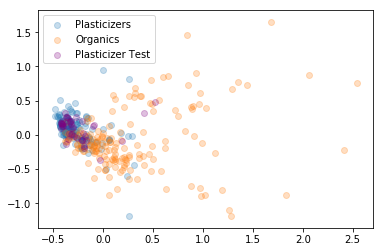

In [35]:
plt.scatter(pl_ics[0][:,0], pl_ics[0][:,1], label='Plasticizers', alpha=0.25)
plt.scatter(org_ics[0][:,0], org_ics[0][:,1], label='Organics', alpha=0.25)
plt.scatter(pl_ics[1][:,0], pl_ics[1][:,1], label='Plasticizer Test', alpha=0.25, c='purple')
# plt.scatter(org_ics[1][:,0], org_ics[1][:,1], label='Organics Test', alpha=0.25, c='pink')
plt.legend(loc='best')
plt.show()

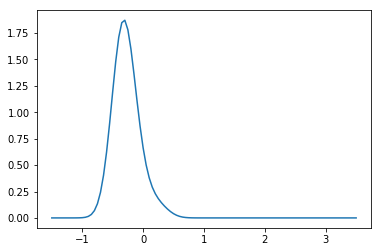

In [36]:
kde, xs = calc_kde(pl_ics[0][:,0], -1.5, 3.5)
plt.plot(xs, kde)
plt.show()

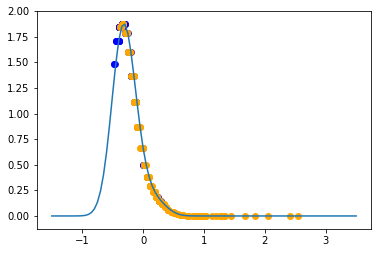

In [37]:
pl_test_kdes = []
pl_train_kdes = []
org_kdes = []
for pl_sample in pl_ics[1][:,0]:
    pl_test_kdes.append(get_kde_value(pl_sample, kde, xs))
for pl_sample in pl_ics[0][:,0]:
    pl_train_kdes.append(get_kde_value(pl_sample, kde, xs))
for org_sample in org_ics[0][:,0]:
    org_kdes.append(get_kde_value(org_sample, kde, xs))
plt.plot(xs, kde)
plt.scatter(pl_ics[1][:,0], pl_test_kdes, c='purple', alpha=0.75)
plt.scatter(pl_ics[0][:,0], pl_train_kdes, c='blue', alpha=0.75)
plt.scatter(org_ics[0][:,0], org_kdes, c='orange')
plt.show()

In [38]:
boundary = 0.4
pl_train_acc = eval_acc(pl_train_kdes, boundary)
pl_test_acc = eval_acc(pl_test_kdes, boundary)
org_hit_percent = eval_acc(org_kdes, boundary)
print("Train Accuracy - {}%".format(round(pl_train_acc*100, 2)))
print("Test Accuracy - {}%".format(round(pl_test_acc*100, 2)))
print("Organic Hit Percent - {}% ({} / {} samples)".format(round(org_hit_percent*100, 2), int(org_hit_percent*len(org_kdes)), len(org_kdes)))

Train Accuracy - 93.45%
Test Accuracy - 92.86%
Organic Hit Percent - 41.07% (69 / 168 samples)


### PCA Component 1 Correlations

In [39]:
train_data = np.concatenate([pl_sets[0], org_sets[0]], axis=0)

train_ics = np.concatenate([pl_ics[0][:,0], org_ics[0][:,0]], axis=0)

In [48]:
feature_correlations = []
for i in range(train_data.shape[1]):
    data1 = train_data[:,i]
    data2 = train_ics
    corr = abs(np.corrcoef(data1, data2)[0][1])
    if pd.isnull(corr):
        print(i)
    feature_correlations.append(corr)

feature_correlations, features = zip(*reversed(sorted(zip(feature_correlations, incl_cols))))

In [49]:
count = 0
high_corr_cats = []
for corr, feat in zip(feature_correlations, features):
    if count < 10:
        print(feat, corr)
        count += 1
        high_corr_cats.append(feat)

VSA_EState3 0.8416094022210964
NumHDonors 0.796998159665549
RingCount 0.7828184620636088
EState_VSA1 0.7822684748129339
NumAliphaticRings 0.7661234456960272
NHOHCount 0.7625034151522584
fr_Al_OH 0.691283482330613
NumAliphaticHeterocycles 0.6744977811610331
NumSaturatedRings 0.6678299558433298
fr_Al_OH_noTert 0.6498688466908683


Highest Feature Correlations - PC1


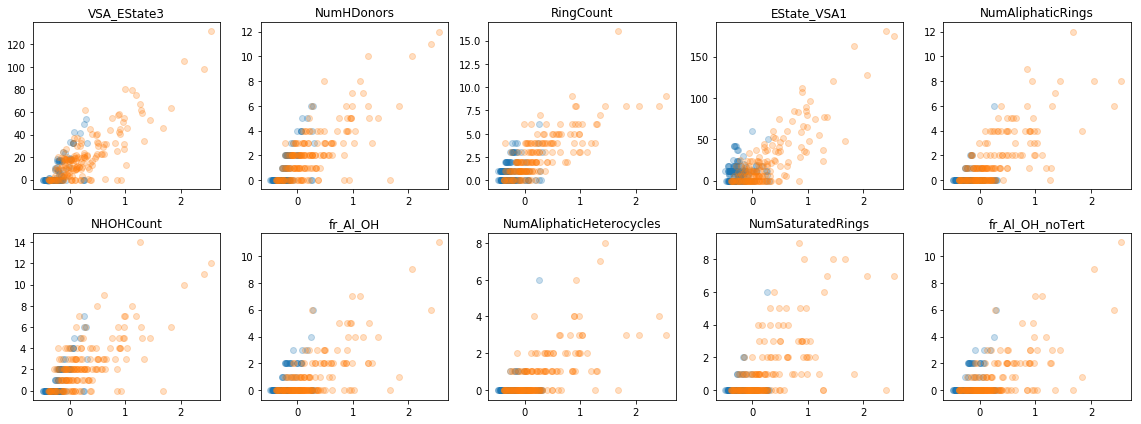

In [54]:
fig, ax = plt.subplots(2, 5, figsize=(16,6))
print('Highest Feature Correlations - PC1')
for i, ax in enumerate(fig.axes):
    ax.scatter(pl_ics[0][:,0], pl_sets[0][:,list(incl_cols).index(high_corr_cats[i])], alpha=0.25)
    ax.scatter(org_ics[0][:,0], org_sets[0][:,list(incl_cols).index(high_corr_cats[i])], alpha=0.25)
    ax.set_title(high_corr_cats[i])
#     sns.distplot(organics[high_corr_cats[i]], kde=True, hist=False, label='Organics', ax=ax)
#     sns.distplot(plasticizers[high_corr_cats[i]], kde=True, hist=False, label='Plasticizers', ax=ax)
fig.tight_layout()
plt.show()

### PCA Component 2 Correlations

In [55]:
train_data = np.concatenate([pl_sets[0], org_sets[0]], axis=0)

train_ics = np.concatenate([pl_ics[0][:,1], org_ics[0][:,1]], axis=0)

In [56]:
feature_correlations = []
for i in range(train_data.shape[1]):
    data1 = train_data[:,i]
    data2 = train_ics
    corr = abs(np.corrcoef(data1, data2)[0][1])
    if pd.isnull(corr):
        print(i)
    feature_correlations.append(corr)

feature_correlations, features = zip(*reversed(sorted(zip(feature_correlations, incl_cols))))

In [57]:
count = 0
high_corr_cats = []
for corr, feat in zip(feature_correlations, features):
    if count < 10:
        print(feat, corr)
        count += 1
        high_corr_cats.append(feat)

SMR_VSA4 0.6101131221198989
NumSaturatedCarbocycles 0.5775812415624941
SlogP_VSA5 0.563221081403681
NumAliphaticCarbocycles 0.5555076795585543
NumSaturatedRings 0.5448666637986042
SlogP_VSA4 0.5340162174957224
NumAliphaticRings 0.4924915883201442
fr_ester 0.47501401045842956
fr_NH0 0.46896750372127904
SMR_VSA3 0.46822530415776126


Highest Feature Correlations - PC1


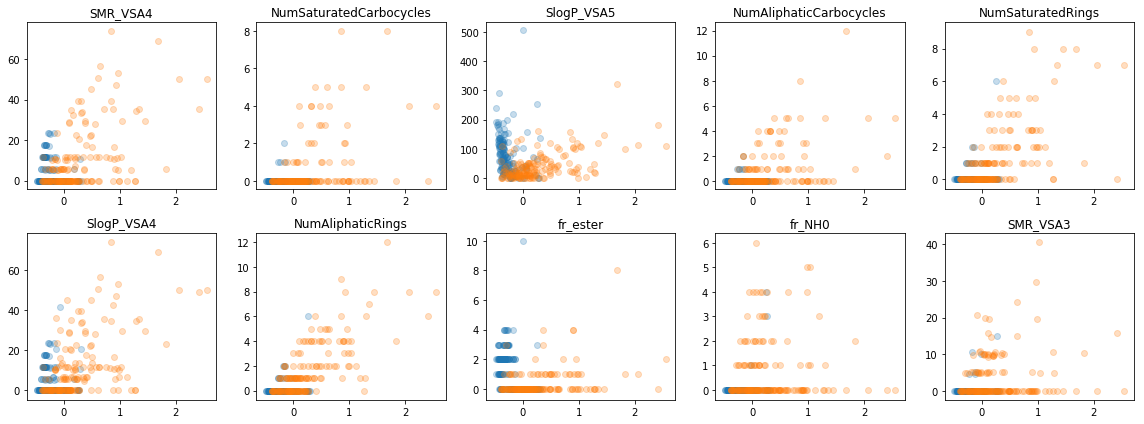

In [58]:
fig, ax = plt.subplots(2, 5, figsize=(16,6))
print('Highest Feature Correlations - PC1')
for i, ax in enumerate(fig.axes):
    ax.scatter(pl_ics[0][:,0], pl_sets[0][:,list(incl_cols).index(high_corr_cats[i])], alpha=0.25)
    ax.scatter(org_ics[0][:,0], org_sets[0][:,list(incl_cols).index(high_corr_cats[i])], alpha=0.25)
    ax.set_title(high_corr_cats[i])
#     sns.distplot(organics[high_corr_cats[i]], kde=True, hist=False, label='Organics', ax=ax)
#     sns.distplot(plasticizers[high_corr_cats[i]], kde=True, hist=False, label='Plasticizers', ax=ax)
fig.tight_layout()
plt.show()

As it stands, the rdkit features are not good enough to distinguish between plasticizers and a random organic molecule from the pubchem database. Aside from counts of functional groups, no structural information is currently included. The next step is to include molecular fingerprints in PCA model. If this does not work then using PCA for plasticizer likelihood will have to be re-evaluated.

# Glycolipids Only

In [ ]:
def calc_kde(xis, lo, hi, h=0.17):
    kde = []
    xs = np.linspace(lo, hi, 101)
    for x in xs:
        kde_sum = 0
        for xi in xis:
            x_prime = (x - xi) / h
            kde_sum += 1 / (1 * math.sqrt(2*math.pi))*math.exp(-(1/2)*((x_prime - 0) / 1)**2)
        kde_sum /= len(xis)*h
        kde.append(kde_sum)
    return kde, xs

def get_kde_value(v, kde, xs):
    for i, x in enumerate(xs):
        if v < x:
            idx = i
            break
    val = kde[i]
    return val

def eval_acc(vs, boundary):
    hits = 0
    for v in vs:
        if v > boundary:
            hits += 1
        else:
            pass
    acc = hits / len(vs)
    return acc

def calc_2D_kde(x_vec, x_range, y_range, gridsize=101):
    # Using Scott's rule of thumb
    d = 2
    std_i = np.std(x_vec[:,0])
    std_j = np.std(x_vec[:,1])
    n = x_vec.shape[0]
    H_i = (n**(-1 / (d + 4))*std_i)**2
    H_j = (n**(-1 / (d + 4))*std_j)**2
    H = np.array([[H_i, 0], [0, H_j]])
    
    xs = np.linspace(x_range[0], x_range[1], gridsize)
    ys = np.linspace(y_range[0], y_range[1], gridsize)
    kde = np.zeros((gridsize, gridsize))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            kde_sum = 0
            for k in range(x_vec.shape[0]):
                xi = x_vec[k,:]
                x_prime = np.array([x, y]) - xi
                val = (2*math.pi)**(-d/2)*(np.linalg.det(H))**(-1/2)*math.exp(-(1/2)*x_prime.T@np.linalg.inv(H)@x_prime)
                kde_sum += val
            kde_sum /= n
            kde[i,j] = kde_sum
    return kde.T, xs, ys

def get_2D_kde_value(v, kde, xs, ys):
    idxs = []
    for i, x in enumerate(xs):
        if v[0] < x:
            idxs.append(i)
            break
    for j, y in enumerate(ys):
        if v[1] < y:
            idxs.append(j)
            break
    val = kde.T[idxs[0], idxs[1]]
    return val

In [ ]:
glip_smiles = glycolips['SMILES'].to_numpy()
pl_smiles = plasticizers['SMILES'].to_numpy()
glip_data = glycolips[rdkit_cols].to_numpy()
pl_data = plasticizers[rdkit_cols].to_numpy()

rand_idxs = np.random.choice(np.arange(len(glip_data)), size=len(glip_data), replace=False)
train_idxs = rand_idxs[:168]
test_idxs = rand_idxs[168:]
glip_tr = glip_data[train_idxs,:]
glip_te = glip_data[test_idxs,:]
glip_smiles_tr = glip_smiles[train_idxs]
glip_smiles_te = glip_smiles[test_idxs]

rand_idxs = np.random.choice(np.arange(len(pl_data)), size=len(pl_data), replace=False)
train_idxs = rand_idxs[:168]
test_idxs = rand_idxs[168:]
pl_tr = pl_data[train_idxs,:]
pl_smiles_train = pl_smiles[train_idxs]
pl_te = pl_data[test_idxs,:]
pl_smiles_test = pl_smiles[test_idxs]

train_data = np.concatenate([pl_tr, glip_tr], axis=0)
test_data = np.concatenate([pl_te, glip_te], axis=0)

In [ ]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
pca = PCA(n_components=2)
train_ics = pca.fit_transform(train_data)
test_ics = pca.transform(test_data)
test_pl_ics = test_ics[:42,:]
test_glip_ics = test_ics[42:,:]

pl_ics = train_ics[:168,:]
glip_ics = train_ics[168:,:]

plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizers', alpha=0.25)
plt.scatter(glip_ics[:,0], glip_ics[:,1], label='Glycolipids', alpha=0.25)
plt.scatter(test_pl_ics[:,0], test_pl_ics[:,1], label='Plasticizer Test', alpha=0.25, c='purple')
plt.scatter(test_glip_ics[:,0], test_glip_ics[:,1], label='Glycolipids Test', alpha=0.25, c='pink')
plt.legend(loc='best')
plt.show()

In [ ]:
kde, xs = calc_kde(pl_ics[:,0], -1.5, 4.5)
plt.plot(xs, kde)
plt.show()

In [ ]:
pl_test_kdes = []
pl_train_kdes = []
glip_kdes = []
for pl_sample in test_pl_ics[:,0]:
    pl_test_kdes.append(get_kde_value(pl_sample, kde, xs))
for pl_sample in pl_ics[:,0]:
    pl_train_kdes.append(get_kde_value(pl_sample, kde, xs))
for glip_sample in test_glip_ics[:,0]:
    glip_kdes.append(get_kde_value(glip_sample, kde, xs))
plt.plot(xs, kde)
plt.scatter(test_pl_ics[:,0], pl_test_kdes, c='purple', alpha=0.75)
plt.scatter(pl_ics[:,0], pl_train_kdes, c='blue', alpha=0.75)
plt.scatter(test_glip_ics[:,0], glip_kdes, c='orange')
plt.show()

In [ ]:
boundary = 0.2
pl_train_acc = eval_acc(pl_train_kdes, boundary)
pl_test_acc = eval_acc(pl_test_kdes, boundary)
glip_hit_percent = eval_acc(glip_kdes, boundary)
print("Train Accuracy - {}%".format(round(pl_train_acc*100, 2)))
print("Test Accuracy - {}%".format(round(pl_test_acc*100, 2)))
print("GlycoLip Hit Percent - {}% ({} / {} samples)".format(round(glip_hit_percent*100, 2), int(glip_hit_percent*len(glip_kdes)), len(glip_kdes)))

In [ ]:
glip_hits_sm = glip_smiles_te[np.where(np.array(glip_kdes) > 0.2)]
glip_hits_kde = np.array(glip_kdes)[np.where(np.array(glip_kdes) > 0.2)]

In [ ]:
glip_hits_kde_best, glip_hits_sm_best = zip(*reversed(sorted(zip(glip_hits_kde, glip_hits_sm))))

In [ ]:
glip_hits_kde_best

In [ ]:
urls = []
for hit in glip_hits_sm_best:
    url = 'https://cactus.nci.nih.gov/chemical/structure/{}/image'.format(hit)
    urls.append(url)

In [ ]:
print(glip_hits_sm_best[0])
Disp.Image(requests.get(urls[0]).content)

In [ ]:
print(glip_hits_sm_best[1])
Disp.Image(requests.get(urls[1]).content)

In [ ]:
print(glip_hits_sm_best[2])
Disp.Image(requests.get(urls[2]).content)

In [ ]:
print(glip_hits_sm_best[3])
Disp.Image(requests.get(urls[3]).content)

In [ ]:
print(glip_hits_sm_best[4])
Disp.Image(requests.get(urls[4]).content)